# Python Processing Step for Multilabel FAIMS Data

### Packages

In [78]:
#Load all my packages
import pandas as pd
import numpy as np
import numpy as np
from numpy import array
from numpy import argmax         #finds the index of the maximum value in a vector
import os
import sklearn
import sklearn.ensemble
import skmultilearn
from scipy import sparse
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from skmultilearn.model_selection import  iterative_train_test_split

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# stuff for exploring the classes
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.dataset import load_dataset
from collections import Counter
from skmultilearn.model_selection import iterative_train_test_split, iterative_stratification
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from skmultilearn.cluster.igraph import IGraphLabelGraphClusterer
import igraph as ig

In [79]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Functions

In [4]:
#Defining the function for adding the pyteomic pieces
from pyteomics import mass
from pyteomics import parser
from pyteomics import electrochem


def addfeatures(featurestable, seqlabel = 'Sequence'):
    Mass = list()
    pI = list()
    Charge = list()
    
    for i in range(0, featurestable.shape[0]):
        ps = parser.parse(featurestable[seqlabel][i], show_unmodified_termini=True)
        
        Mass.append(mass.calculate_mass(parsed_sequence=ps))
        Charge.append(electrochem.charge(ps, 2.5))
        pI.append(electrochem.pI(featurestable[seqlabel][i]))
        
    
    featurestable['pyMass'] = Mass
    featurestable['pI'] = pI
    featurestable['pyCharge'] = Charge
    
    return(featurestable)



#WANT TO TRY ONE-HOT WITH LIST THAT I THEN CONVERT INTO FRAME AFTERWARD
#WOULD ALSO ALLOW FOR THE USE OF THE KARAS PADDING FUNCTION SO THAT I CAN HIT THEM ALL WITH ZEROS AT THE SAME TIME



def simpleOneHot(data_frame, sequenceTag = 'ModSequence', alphabet = 'ACDEFGHIKLMNPQRSTVWY'):
    #Start by finding the max and calculating needed vector length
    VEC_LENGTH = max(data_frame['Length']) * len(alphabet)
    
    #Define what residues are possible
    AMINO_ACIDS = alphabet 
    
    #TURNING CHARACTERS INTO INTEGERS
    # Map character keys to integer values in a dictionary, then map integer keys to character values to revers transform
    char_to_int = dict((c, i) for i, c in enumerate(AMINO_ACIDS))   #character keys to integer values
    int_to_char = dict((i, c) for i, c in enumerate(AMINO_ACIDS))   #integer keys to character values
    
    
    hotlist = list()
    #Build out the rest of the sequences' one-hot arrays
    
    for i in range(0, data_frame.shape[0]):
        
        pep = data_frame[sequenceTag][i]
        #print(pep)
        integer_encode = [char_to_int[char] for char in pep]
        encoded = to_categorical(integer_encode, num_classes=22)
        flatencode = encoded.flatten()
        
        #numzeros = VEC_LENGTH - len(flatencode)
        #flatencode = np.append(flatencode, [[0] * numzeros])
        
        hotlist.append(flatencode)
    
    padded = pad_sequences(hotlist, padding= 'post', maxlen=VEC_LENGTH)
    
    hotarray = np.array(padded)
    
    hotarray.shape
    return(hotarray)

### Processing

In [45]:
#Bringing in the the final labelling scheme data and adding the other features
df = pd.read_csv("P:/JGM_FAIMS_CVprediction/JMM_PreProcessed_Data/50percentMaxPlusThreshold.csv", low_memory=False) #read in data generated from R preprocessing
#data_df = addfeatures(data_df)
#data_hotarray = simpleOneHot(data_frame=data_df, alphabet='ACDEFGHIKLMNPQRSTVWYam')
#feature_subset = ['Charge', 'Length', 'pyMass', 'pI']
#Generating X and y, features and labels respectively 
#seq = np.concatenate((data_df[feature_subset], data_hotarray), axis = 1)
y = data_df.loc[ : ,  'X20':'X95'].values

In [46]:
df.head()

,SeqCharge,X20,X25,X30,X35,X40,X45,X50,X55,X60,...,X80,X85,X90,X95,maxcv_naomit,Charge,ModSequence,Length,Sequence,LabelSequence
0,2AACLCFR,0,0,0,0,0,0,1,1,1,...,0,0,0,0,50,2,AACLCFR,7,AACLCFR,1110000000
1,2SEQEDEVLLVSSSR,0,0,0,1,1,0,0,0,0,...,0,0,0,0,40,2,SEQEDEVLLVSSSR,14,SEQEDEVLLVSSSR,1100000000000
2,3SEQEDEVLLVSSSR,0,0,0,0,0,0,0,1,1,...,0,0,0,0,60,3,SEQEDEVLLVSSSR,14,SEQEDEVLLVSSSR,111100000
3,2YPDQWIVPGGGMEPEEEPGGAAVR,0,1,1,0,0,0,0,0,0,...,0,0,0,0,30,2,YPDQWIVPGGGMEPEEEPGGAAVR,24,YPDQWIVPGGGMEPEEEPGGAAVR,110000000000000
4,3YPDQWIVPGGGMEPEEEPGGAAVR,0,0,0,0,0,0,0,0,1,...,0,0,0,0,70,3,YPDQWIVPGGGMEPEEEPGGAAVR,24,YPDQWIVPGGGMEPEEEPGGAAVR,11100000


In [47]:
### combine all the letters into a long string, take the set to find the unique values, add 'END' (for use with one-hot), then get length
seq = df['SeqCharge']
vocab = set(''.join([str(i) for i in seq]))
vocab.add('END')
len_vocab = len(vocab)
print(len_vocab)

27


In [48]:
vocab

{'2',
 '3',
 '4',
 '5',
 'A',
 'C',
 'D',
 'E',
 'END',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 'a',
 'm'}

In [52]:
cv = df['maxcv_naomit']
set(cv)

{20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95}

In [54]:
y.shape

(122847, 16)

In [55]:
seq.shape

(122847,)

In [56]:
seq[0]

'2AACLCFR'

In [57]:
y[0]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [61]:
## make index of the characters in vocab
char_index = dict((c, i) for i, c in enumerate(vocab))
maxlen = max([len(x) for x in df.SeqCharge])
print(char_index)
print(maxlen)

{'Y': 0, '5': 1, 'T': 2, 'S': 3, 'G': 4, '2': 5, 'F': 6, 'A': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'Q': 12, 'a': 13, 'D': 14, '3': 15, 'V': 16, 'P': 17, 'C': 18, 'END': 19, 'W': 20, 'E': 21, 'M': 22, 'N': 23, 'm': 24, '4': 25, 'R': 26}
51


In [62]:
#take input upto max and truncate rest
# get index in char_index
#padd 'END' to shorter sequences

x = []
x_name = [str(i)[0:maxlen] for i in seq]
for i in x_name:
    tmp = [char_index[j] for j in str(i)]
    for k in range(0,maxlen - len(str(i))):
        tmp.append(char_index["END"])
    x.append(tmp)

In [65]:
seq[0]

'2AACLCFR'

In [64]:
x[0]

[5,
 7,
 7,
 18,
 10,
 18,
 6,
 26,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19]

In [84]:
seq

0                          2AACLCFR
1                   2SEQEDEVLLVSSSR
2                   3SEQEDEVLLVSSSR
3         2YPDQWIVPGGGMEPEEEPGGAAVR
4         3YPDQWIVPGGGMEPEEEPGGAAVR
                    ...            
122842              2AHTSSTQLQEELEK
122843              3AHTSSTQLQEELEK
122844                   2VVESPDFSK
122845                 2TMNISPEQPQH
122846                 2TmNISPEQPQH
Name: SeqCharge, Length: 122847, dtype: object

In [91]:
np.asarray(x)[0]

array([ 5,  7,  7, 18, 10, 18,  6, 26, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19])

In [87]:
y[0]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [92]:
#Split the 50%+ threshold data into train and test keeping label distribution proportional
X_train, y_train, X_test, y_test = iterative_train_test_split(np.asarray(x), y, test_size=0.30)
X_train.shape

(85991, 51)

In [93]:
y_train[0]


array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [94]:
X_train[0]

array([ 5,  7,  7, 18, 10, 18,  6, 26, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19])

# Explore the classes

In [13]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y)
print("{} labels, {} edges".format(len(y[1]), len(edge_map)))
print(edge_map)

16 labels, 66 edges
{(6, 7): 16741.0, (6, 8): 5937.0, (7, 8): 14873.0, (3, 4): 12975.0, (7, 9): 4052.0, (8, 9): 9697.0, (7, 10): 1460.0, (8, 10): 5288.0, (9, 10): 8372.0, (1, 2): 3055.0, (10, 11): 7697.0, (2, 3): 7371.0, (10, 12): 3232.0, (11, 12): 5122.0, (4, 5): 17640.0, (4, 6): 4292.0, (5, 6): 17998.0, (3, 5): 1498.0, (11, 13): 2064.0, (12, 13): 2976.0, (11, 14): 649.0, (12, 14): 1190.0, (13, 14): 1618.0, (5, 7): 5137.0, (10, 13): 1010.0, (0, 1): 533.0, (12, 15): 328.0, (13, 15): 573.0, (14, 15): 803.0, (7, 11): 140.0, (8, 11): 1317.0, (9, 11): 2889.0, (5, 8): 536.0, (8, 12): 194.0, (9, 12): 587.0, (9, 13): 81.0, (6, 9): 509.0, (11, 15): 140.0, (3, 6): 60.0, (3, 7): 11.0, (4, 7): 206.0, (6, 10): 110.0, (2, 4): 461.0, (0, 2): 42.0, (0, 3): 1.0, (1, 3): 57.0, (8, 13): 26.0, (3, 8): 1.0, (4, 8): 23.0, (10, 14): 227.0, (10, 15): 37.0, (4, 9): 2.0, (5, 9): 15.0, (4, 10): 1.0, (5, 10): 6.0, (9, 14): 6.0, (2, 5): 24.0, (1, 4): 5.0, (7, 12): 19.0, (5, 11): 2.0, (6, 11): 6.0, (5, 12): 1.0, (

In [14]:
# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

In [15]:
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer_igraph.fit_predict(X_keys, y)
partition

array([list([0, 1, 2, 3, 4, 5, 6]),
       list([7, 8, 9, 10, 11, 12, 13, 14, 15])], dtype=object)

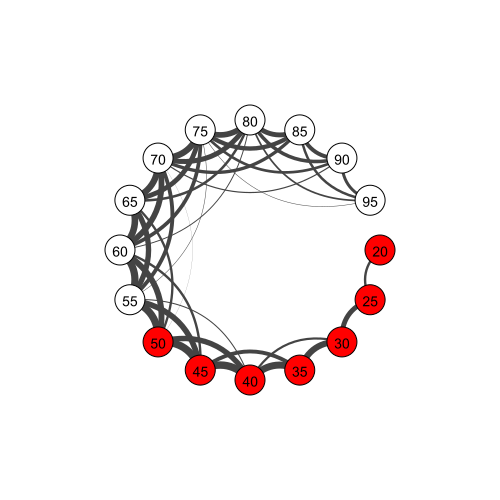

In [38]:

colors = ['red', 'white', 'blue', 'green']
membership_vector = to_membership_vector(partition)
visual_style = {
    "vertex_size" : 30,
    "vertex_label": [ x[1:] for x in data_df.loc[ : ,  'X20':'X95'].columns.values],
    "edge_width" : [np.log2(x/100) for x in clusterer_igraph.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(y.shape[1])],
    "bbox": (500,500),
    "margin": 120,
    "layout": clusterer_igraph.graph_.layout_circle(),
    "autocurve":True,
    "edge_curved":0.5
}

def testplot(graph, name):
    graph.vs['label'] = graph.vs['name']
    out = ig.plot(clusterer_igraph.graph_, **visual_style)
    out.save(name + '_all_peptides.png')
    
testplot(clusterer_igraph.graph_, 'test1')
ig.plot(clusterer_igraph.graph_, **visual_style)
#ig.write(clusterer_igraph.graph_, filename="test.svg")

In [39]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(y[1]), len(edge_map)))
print(edge_map)
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer_igraph.fit_predict(X_keys, y_train)
partition

16 labels, 64 edges
{(6, 7): 11719.0, (6, 8): 4142.0, (7, 8): 10411.0, (8, 9): 6788.0, (8, 10): 3705.0, (9, 10): 5860.0, (10, 11): 5388.0, (2, 3): 5160.0, (1, 2): 2138.0, (4, 5): 12348.0, (3, 4): 9082.0, (3, 5): 1036.0, (10, 12): 2274.0, (11, 12): 3585.0, (5, 6): 12599.0, (4, 6): 3030.0, (5, 7): 3612.0, (12, 13): 2083.0, (12, 14): 823.0, (13, 14): 1133.0, (7, 9): 2831.0, (7, 10): 1028.0, (9, 11): 2008.0, (5, 8): 376.0, (8, 11): 910.0, (14, 15): 562.0, (11, 13): 1477.0, (11, 14): 459.0, (11, 15): 101.0, (12, 15): 227.0, (13, 15): 406.0, (9, 12): 418.0, (6, 9): 370.0, (6, 10): 86.0, (3, 6): 42.0, (0, 1): 373.0, (10, 13): 738.0, (0, 2): 32.0, (0, 3): 1.0, (1, 3): 38.0, (8, 12): 146.0, (8, 13): 19.0, (9, 13): 62.0, (4, 7): 145.0, (2, 4): 311.0, (4, 8): 16.0, (10, 14): 166.0, (10, 15): 29.0, (7, 11): 97.0, (4, 9): 1.0, (5, 9): 11.0, (4, 10): 1.0, (5, 10): 5.0, (1, 4): 2.0, (2, 5): 19.0, (7, 12): 15.0, (5, 11): 2.0, (6, 11): 5.0, (5, 12): 1.0, (6, 12): 1.0, (3, 7): 8.0, (9, 14): 5.0, (2, 6):

array([list([0, 1, 2, 3, 4, 5, 6]),
       list([7, 8, 9, 10, 11, 12, 13, 14, 15])], dtype=object)

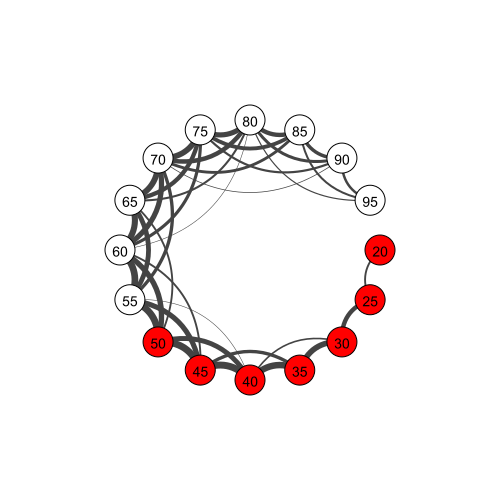

In [40]:
### plottrain set
colors = ['red', 'white', 'blue', 'green']
membership_vector = to_membership_vector(partition)
visual_style = {
    "vertex_size" : 30,
    "vertex_label": [ x[1:] for x in data_df.loc[ : ,  'X20':'X95'].columns.values],
    "edge_width" : [np.log2(x/100) for x in clusterer_igraph.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(y.shape[1])],
    "bbox": (500,500),
    "margin": 120,
    "layout": clusterer_igraph.graph_.layout_circle(),
    "autocurve":True,
    "edge_curved":0.5
}

def testplot(graph, name):
    graph.vs['label'] = graph.vs['name']
    out = ig.plot(clusterer_igraph.graph_, **visual_style)
    out.save(name + '_train_peptides.png')
    
testplot(clusterer_igraph.graph_, 'test1')
ig.plot(clusterer_igraph.graph_, **visual_style)
#ig.write(clusterer_igraph.graph_, filename="test.svg")

In [41]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y_test)
print("{} labels, {} edges".format(len(y[1]), len(edge_map)))
print(edge_map)
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer_igraph.fit_predict(X_keys, y_test)
partition

16 labels, 60 edges
{(3, 4): 3893.0, (7, 8): 4462.0, (7, 9): 1221.0, (8, 9): 2909.0, (7, 10): 432.0, (8, 10): 1583.0, (9, 10): 2512.0, (1, 2): 917.0, (6, 7): 5022.0, (10, 11): 2309.0, (10, 12): 958.0, (11, 12): 1537.0, (2, 3): 2211.0, (4, 5): 5292.0, (4, 6): 1262.0, (5, 6): 5399.0, (11, 13): 587.0, (12, 13): 893.0, (11, 14): 190.0, (12, 14): 367.0, (13, 14): 485.0, (5, 7): 1525.0, (10, 13): 272.0, (0, 1): 160.0, (12, 15): 101.0, (13, 15): 167.0, (14, 15): 241.0, (7, 11): 43.0, (8, 11): 407.0, (9, 11): 881.0, (6, 8): 1795.0, (5, 8): 160.0, (3, 5): 462.0, (8, 12): 48.0, (9, 12): 169.0, (9, 13): 19.0, (6, 9): 139.0, (3, 6): 18.0, (3, 7): 3.0, (4, 7): 61.0, (6, 10): 24.0, (2, 4): 150.0, (3, 8): 1.0, (4, 8): 7.0, (10, 14): 61.0, (0, 2): 10.0, (8, 13): 7.0, (11, 15): 39.0, (9, 14): 1.0, (2, 5): 5.0, (5, 9): 4.0, (5, 10): 1.0, (1, 3): 19.0, (7, 12): 4.0, (10, 15): 8.0, (1, 4): 3.0, (2, 6): 1.0, (6, 11): 1.0, (4, 9): 1.0, (7, 13): 1.0}


array([list([0, 1, 2, 3, 4, 5, 6]),
       list([7, 8, 9, 10, 11, 12, 13, 14, 15])], dtype=object)

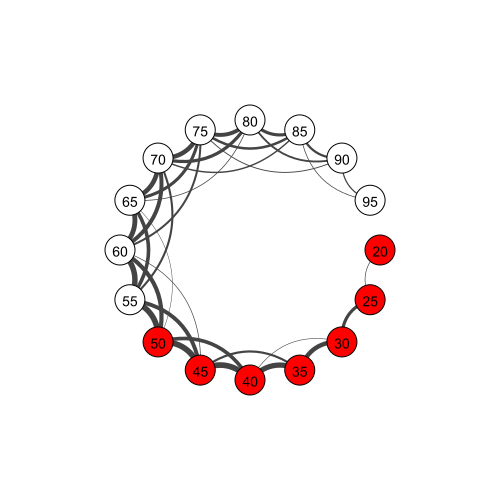

In [42]:
### plottrain set
colors = ['red', 'white', 'blue', 'green']
membership_vector = to_membership_vector(partition)
visual_style = {
    "vertex_size" : 30,
    "vertex_label": [ x[1:] for x in data_df.loc[ : ,  'X20':'X95'].columns.values],
    "edge_width" : [np.log2(x/100) for x in clusterer_igraph.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(y.shape[1])],
    "bbox": (500,500),
    "margin": 120,
    "layout": clusterer_igraph.graph_.layout_circle(),
    "autocurve":True,
    "edge_curved":0.5
}

def testplot(graph, name):
    graph.vs['label'] = graph.vs['name']
    out = ig.plot(clusterer_igraph.graph_, **visual_style)
    out.save(name + '_test_peptides.png')
    
testplot(clusterer_igraph.graph_, 'test1')
ig.plot(clusterer_igraph.graph_, **visual_style)
#ig.write(clusterer_igraph.graph_, filename="test.svg")

# Model

In [68]:
len(set(cv))

16

In [95]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [112]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=51, output_dim=40))
model.add(layers.LSTM(128, return_sequences=True, input_shape=(maxlen,len_vocab)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(128, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(set(cv)), activation='sigmoid'))
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam', **kwargs
)
model.compile(loss=tf.keras.losses.BinaryCrossentropy, optimizer=adam,  metrics=[tf.keras.metrics.BinaryAccuracy()])

NameError: name 'kwargs' is not defined

In [109]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 40)          2040      
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 128)         86528     
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_16 (Dense)             (None, 16)               

In [110]:
hist = model.fit(X_train, y_train, epochs=25, batch_size=2048, workers=4, validation_data=(X_test, y_test))

Train on 85991 samples, validate on 36856 samples
Epoch 1/25
85991/85991 [==============================] - 7s 76us/sample - loss: 0.3908 - binary_accuracy: 0.8481 - val_loss: 0.3344 - val_binary_accuracy: 0.8727
Epoch 2/25
85991/85991 [==============================] - 4s 41us/sample - loss: 0.3371 - binary_accuracy: 0.8726 - val_loss: 0.3344 - val_binary_accuracy: 0.8727
Epoch 3/25
85991/85991 [==============================] - 4s 41us/sample - loss: 0.3362 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 4/25
85991/85991 [==============================] - 4s 41us/sample - loss: 0.3358 - binary_accuracy: 0.8726 - val_loss: 0.3344 - val_binary_accuracy: 0.8727
Epoch 5/25
85991/85991 [==============================] - 4s 41us/sample - loss: 0.3355 - binary_accuracy: 0.8726 - val_loss: 0.3345 - val_binary_accuracy: 0.8727
Epoch 6/25
85991/85991 [==============================] - 4s 42us/sample - loss: 0.3354 - binary_accuracy: 0.8726 - val_loss: 0.3346 - 

In [111]:
hist = model.fit(X_train, y_train, epochs=1000, batch_size=2048, workers=4, validation_data=(X_test, y_test))

Train on 85991 samples, validate on 36856 samples
Epoch 1/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3347 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 2/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.3347 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 3/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.3347 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 4/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.3347 - binary_accuracy: 0.8726 - val_loss: 0.3344 - val_binary_accuracy: 0.8727
Epoch 5/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.3347 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 6/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3346 - binary_accuracy: 0.8726 - val_los

85991/85991 [==============================] - 3s 36us/sample - loss: 0.3346 - binary_accuracy: 0.8726 - val_loss: 0.3344 - val_binary_accuracy: 0.8727
Epoch 51/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3346 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 52/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3346 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 53/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3346 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 54/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3346 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 55/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3345 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 56/1000
8599

85991/85991 [==============================] - 3s 37us/sample - loss: 0.3344 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727343 - binary_
Epoch 99/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3345 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 100/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3345 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 101/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3345 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727- binary_accuracy: 0 - ETA: 0s - loss: 0.3344 - binary_accuracy: 0.872
Epoch 102/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3344 - binary_accuracy: 0.8726 - val_loss: 0.3343 - val_binary_accuracy: 0.8727
Epoch 103/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.3344 - bina

85991/85991 [==============================] - 3s 37us/sample - loss: 0.2252 - binary_accuracy: 0.8937 - val_loss: 0.2235 - val_binary_accuracy: 0.8934
Epoch 147/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.2227 - binary_accuracy: 0.8945 - val_loss: 0.2210 - val_binary_accuracy: 0.8950
Epoch 148/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.2205 - binary_accuracy: 0.8953 - val_loss: 0.2172 - val_binary_accuracy: 0.8966
Epoch 149/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.2186 - binary_accuracy: 0.8961 - val_loss: 0.2159 - val_binary_accuracy: 0.8969
Epoch 150/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.2167 - binary_accuracy: 0.8967 - val_loss: 0.2151 - val_binary_accuracy: 0.8973
Epoch 151/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.2164 - binary_accuracy: 0.8970 - val_loss: 0.2136 - val_binary_accuracy: 0.8981
Epoch 152/100

85991/85991 [==============================] - 3s 37us/sample - loss: 0.1923 - binary_accuracy: 0.9089 - val_loss: 0.1973 - val_binary_accuracy: 0.9059
Epoch 196/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1921 - binary_accuracy: 0.9092 - val_loss: 0.1967 - val_binary_accuracy: 0.9062
Epoch 197/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1919 - binary_accuracy: 0.9092 - val_loss: 0.1971 - val_binary_accuracy: 0.9057
Epoch 198/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1913 - binary_accuracy: 0.9096 - val_loss: 0.1970 - val_binary_accuracy: 0.9060
Epoch 199/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1913 - binary_accuracy: 0.9095 - val_loss: 0.1994 - val_binary_accuracy: 0.9052
Epoch 200/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1910 - binary_accuracy: 0.9096 - val_loss: 0.1962 - val_binary_accuracy: 0.9064
Epoch 201/100

85991/85991 [==============================] - 3s 37us/sample - loss: 0.1749 - binary_accuracy: 0.9187 - val_loss: 0.2002 - val_binary_accuracy: 0.9063
Epoch 245/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1749 - binary_accuracy: 0.9187 - val_loss: 0.1988 - val_binary_accuracy: 0.9068
Epoch 246/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1741 - binary_accuracy: 0.9189 - val_loss: 0.1984 - val_binary_accuracy: 0.9073
Epoch 247/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1735 - binary_accuracy: 0.9193 - val_loss: 0.2007 - val_binary_accuracy: 0.9054
Epoch 248/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1738 - binary_accuracy: 0.9192 - val_loss: 0.1999 - val_binary_accuracy: 0.9062
Epoch 249/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1725 - binary_accuracy: 0.9200 - val_loss: 0.1997 - val_binary_accuracy: 0.9067
Epoch 250/100

Epoch 293/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1556 - binary_accuracy: 0.9292 - val_loss: 0.2139 - val_binary_accuracy: 0.9048
Epoch 294/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1552 - binary_accuracy: 0.9293 - val_loss: 0.2164 - val_binary_accuracy: 0.9041
Epoch 295/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.1552 - binary_accuracy: 0.9294 - val_loss: 0.2149 - val_binary_accuracy: 0.9043
Epoch 296/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1544 - binary_accuracy: 0.9297 - val_loss: 0.2156 - val_binary_accuracy: 0.9043
Epoch 297/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1541 - binary_accuracy: 0.9300 - val_loss: 0.2152 - val_binary_accuracy: 0.9046
Epoch 298/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1536 - binary_accuracy: 0.9303 - val_loss: 0.2197 - val_binary_accuracy: 0.903

85991/85991 [==============================] - 3s 37us/sample - loss: 0.1397 - binary_accuracy: 0.9375 - val_loss: 0.2374 - val_binary_accuracy: 0.9021
Epoch 343/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1389 - binary_accuracy: 0.9382 - val_loss: 0.2399 - val_binary_accuracy: 0.9013
Epoch 344/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1391 - binary_accuracy: 0.9378 - val_loss: 0.2367 - val_binary_accuracy: 0.9020
Epoch 345/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1384 - binary_accuracy: 0.9382 - val_loss: 0.2381 - val_binary_accuracy: 0.9014
Epoch 346/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.1383 - binary_accuracy: 0.9383 - val_loss: 0.2395 - val_binary_accuracy: 0.9017
Epoch 347/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1388 - binary_accuracy: 0.9381 - val_loss: 0.2400 - val_binary_accuracy: 0.9018
Epoch 348/100

Epoch 391/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1268 - binary_accuracy: 0.9444 - val_loss: 0.2599 - val_binary_accuracy: 0.9005
Epoch 392/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1265 - binary_accuracy: 0.9443 - val_loss: 0.2623 - val_binary_accuracy: 0.8994
Epoch 393/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1265 - binary_accuracy: 0.9444 - val_loss: 0.2627 - val_binary_accuracy: 0.8992
Epoch 394/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1270 - binary_accuracy: 0.9440 - val_loss: 0.2621 - val_binary_accuracy: 0.8997
Epoch 395/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1259 - binary_accuracy: 0.9446 - val_loss: 0.2641 - val_binary_accuracy: 0.8997
Epoch 396/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1262 - binary_accuracy: 0.9444 - val_loss: 0.2637 - val_binary_accuracy: 0.899

85991/85991 [==============================] - 3s 37us/sample - loss: 0.1174 - binary_accuracy: 0.9490 - val_loss: 0.2816 - val_binary_accuracy: 0.8983
Epoch 441/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1177 - binary_accuracy: 0.9488 - val_loss: 0.2812 - val_binary_accuracy: 0.8993
Epoch 442/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.1176 - binary_accuracy: 0.9488 - val_loss: 0.2829 - val_binary_accuracy: 0.8991
Epoch 443/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1169 - binary_accuracy: 0.9490 - val_loss: 0.2826 - val_binary_accuracy: 0.8984
Epoch 444/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.1169 - binary_accuracy: 0.9490 - val_loss: 0.2820 - val_binary_accuracy: 0.8986
Epoch 445/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1165 - binary_accuracy: 0.9493 - val_loss: 0.2842 - val_binary_accuracy: 0.8981
Epoch 446/100

85991/85991 [==============================] - 3s 37us/sample - loss: 0.1105 - binary_accuracy: 0.9523 - val_loss: 0.2959 - val_binary_accuracy: 0.8978
Epoch 489/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1098 - binary_accuracy: 0.9526 - val_loss: 0.3013 - val_binary_accuracy: 0.8975
Epoch 490/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1100 - binary_accuracy: 0.9526 - val_loss: 0.2987 - val_binary_accuracy: 0.8978
Epoch 491/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.1096 - binary_accuracy: 0.9526 - val_loss: 0.2980 - val_binary_accuracy: 0.8972
Epoch 492/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1098 - binary_accuracy: 0.9526 - val_loss: 0.3027 - val_binary_accuracy: 0.8969
Epoch 493/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.1093 - binary_accuracy: 0.9528 - val_loss: 0.3017 - val_binary_accuracy: 0.8972
Epoch 494/100

85991/85991 [==============================] - 3s 37us/sample - loss: 0.1039 - binary_accuracy: 0.9554 - val_loss: 0.3137 - val_binary_accuracy: 0.8970
Epoch 538/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1033 - binary_accuracy: 0.9557 - val_loss: 0.3189 - val_binary_accuracy: 0.8961
Epoch 539/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1033 - binary_accuracy: 0.9556 - val_loss: 0.3217 - val_binary_accuracy: 0.8962
Epoch 540/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.1036 - binary_accuracy: 0.9556 - val_loss: 0.3169 - val_binary_accuracy: 0.8970
Epoch 541/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.1032 - binary_accuracy: 0.9558 - val_loss: 0.3185 - val_binary_accuracy: 0.8965
Epoch 542/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.1026 - binary_accuracy: 0.9560 - val_loss: 0.3197 - val_binary_accuracy: 0.8962
Epoch 543/100

85991/85991 [==============================] - 3s 37us/sample - loss: 0.0985 - binary_accuracy: 0.9580 - val_loss: 0.3355 - val_binary_accuracy: 0.8964
Epoch 587/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0990 - binary_accuracy: 0.9578 - val_loss: 0.3333 - val_binary_accuracy: 0.8969
Epoch 588/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0979 - binary_accuracy: 0.9583 - val_loss: 0.3408 - val_binary_accuracy: 0.8962
Epoch 589/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0977 - binary_accuracy: 0.9583 - val_loss: 0.3323 - val_binary_accuracy: 0.8961
Epoch 590/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0978 - binary_accuracy: 0.9582 - val_loss: 0.3352 - val_binary_accuracy: 0.8965
Epoch 591/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0975 - binary_accuracy: 0.9584 - val_loss: 0.3396 - val_binary_accuracy: 0.8962
Epoch 592/100

Epoch 635/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0954 - binary_accuracy: 0.9594 - val_loss: 0.3455 - val_binary_accuracy: 0.8957
Epoch 636/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0937 - binary_accuracy: 0.9603 - val_loss: 0.3474 - val_binary_accuracy: 0.8964
Epoch 637/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0934 - binary_accuracy: 0.9604 - val_loss: 0.3506 - val_binary_accuracy: 0.8963
Epoch 638/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0933 - binary_accuracy: 0.9603 - val_loss: 0.3495 - val_binary_accuracy: 0.8962
Epoch 639/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0943 - binary_accuracy: 0.9601 - val_loss: 0.3465 - val_binary_accuracy: 0.8960
Epoch 640/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0934 - binary_accuracy: 0.9602 - val_loss: 0.3491 - val_binary_accuracy: 0.895

85991/85991 [==============================] - 3s 37us/sample - loss: 0.0900 - binary_accuracy: 0.9619 - val_loss: 0.3629 - val_binary_accuracy: 0.8953
Epoch 684/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0902 - binary_accuracy: 0.9617 - val_loss: 0.3605 - val_binary_accuracy: 0.8954
Epoch 685/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0894 - binary_accuracy: 0.9621 - val_loss: 0.3629 - val_binary_accuracy: 0.8957
Epoch 686/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0896 - binary_accuracy: 0.9622 - val_loss: 0.3624 - val_binary_accuracy: 0.8952
Epoch 687/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0895 - binary_accuracy: 0.9621 - val_loss: 0.3636 - val_binary_accuracy: 0.8955
Epoch 688/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0901 - binary_accuracy: 0.9617 - val_loss: 0.3647 - val_binary_accuracy: 0.8952
Epoch 689/100

85991/85991 [==============================] - 3s 36us/sample - loss: 0.0866 - binary_accuracy: 0.9635 - val_loss: 0.3711 - val_binary_accuracy: 0.8951
Epoch 732/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0870 - binary_accuracy: 0.9631 - val_loss: 0.3720 - val_binary_accuracy: 0.8954
Epoch 733/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0861 - binary_accuracy: 0.9637 - val_loss: 0.3757 - val_binary_accuracy: 0.8949
Epoch 734/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0858 - binary_accuracy: 0.9639 - val_loss: 0.3788 - val_binary_accuracy: 0.8951
Epoch 735/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0863 - binary_accuracy: 0.9635 - val_loss: 0.3754 - val_binary_accuracy: 0.8947
Epoch 736/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.0867 - binary_accuracy: 0.9633 - val_loss: 0.3733 - val_binary_accuracy: 0.8944
Epoch 737/100

Epoch 780/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.0826 - binary_accuracy: 0.9652 - val_loss: 0.3916 - val_binary_accuracy: 0.8948
Epoch 781/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0832 - binary_accuracy: 0.9650 - val_loss: 0.3920 - val_binary_accuracy: 0.8947
Epoch 782/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0830 - binary_accuracy: 0.9651 - val_loss: 0.3876 - val_binary_accuracy: 0.8950
Epoch 783/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0832 - binary_accuracy: 0.9650 - val_loss: 0.3866 - val_binary_accuracy: 0.8950
Epoch 784/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0830 - binary_accuracy: 0.9651 - val_loss: 0.3908 - val_binary_accuracy: 0.8948
Epoch 785/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0825 - binary_accuracy: 0.9653 - val_loss: 0.3857 - val_binary_accuracy: 0.894

85991/85991 [==============================] - 3s 37us/sample - loss: 0.0812 - binary_accuracy: 0.9659 - val_loss: 0.4024 - val_binary_accuracy: 0.8946
Epoch 829/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0795 - binary_accuracy: 0.9667 - val_loss: 0.4039 - val_binary_accuracy: 0.8944
Epoch 830/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0803 - binary_accuracy: 0.9664 - val_loss: 0.4029 - val_binary_accuracy: 0.8944
Epoch 831/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0808 - binary_accuracy: 0.9662 - val_loss: 0.3941 - val_binary_accuracy: 0.8942
Epoch 832/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0806 - binary_accuracy: 0.9662 - val_loss: 0.3944 - val_binary_accuracy: 0.8946
Epoch 833/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0800 - binary_accuracy: 0.9666 - val_loss: 0.4060 - val_binary_accuracy: 0.8944
Epoch 834/100

85991/85991 [==============================] - 3s 37us/sample - loss: 0.0779 - binary_accuracy: 0.9674 - val_loss: 0.4140 - val_binary_accuracy: 0.8940
Epoch 878/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.0774 - binary_accuracy: 0.9675 - val_loss: 0.4161 - val_binary_accuracy: 0.8939
Epoch 879/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0776 - binary_accuracy: 0.9676 - val_loss: 0.4168 - val_binary_accuracy: 0.89380s - loss: 0.0777 - binary_accura
Epoch 880/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0781 - binary_accuracy: 0.9673 - val_loss: 0.4127 - val_binary_accuracy: 0.8942
Epoch 881/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0784 - binary_accuracy: 0.9672 - val_loss: 0.4082 - val_binary_accuracy: 0.8940
Epoch 882/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0783 - binary_accuracy: 0.9672 - val_loss: 0.4073 - val_bina

85991/85991 [==============================] - 3s 37us/sample - loss: 0.0759 - binary_accuracy: 0.9682 - val_loss: 0.4264 - val_binary_accuracy: 0.8934
Epoch 926/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0749 - binary_accuracy: 0.9687 - val_loss: 0.4271 - val_binary_accuracy: 0.8938
Epoch 927/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.0755 - binary_accuracy: 0.9685 - val_loss: 0.4292 - val_binary_accuracy: 0.8936
Epoch 928/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0757 - binary_accuracy: 0.9683 - val_loss: 0.4234 - val_binary_accuracy: 0.8934
Epoch 929/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.0752 - binary_accuracy: 0.9686 - val_loss: 0.4307 - val_binary_accuracy: 0.8931
Epoch 930/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0743 - binary_accuracy: 0.9691 - val_loss: 0.4325 - val_binary_accuracy: 0.8935
Epoch 931/100

85991/85991 [==============================] - 3s 37us/sample - loss: 0.0731 - binary_accuracy: 0.9695 - val_loss: 0.4370 - val_binary_accuracy: 0.8933
Epoch 975/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0727 - binary_accuracy: 0.9698 - val_loss: 0.4390 - val_binary_accuracy: 0.8937
Epoch 976/1000
85991/85991 [==============================] - 3s 36us/sample - loss: 0.0731 - binary_accuracy: 0.9695 - val_loss: 0.4366 - val_binary_accuracy: 0.8931
Epoch 977/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0733 - binary_accuracy: 0.9695 - val_loss: 0.4367 - val_binary_accuracy: 0.8931
Epoch 978/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0739 - binary_accuracy: 0.9691 - val_loss: 0.4345 - val_binary_accuracy: 0.8930
Epoch 979/1000
85991/85991 [==============================] - 3s 37us/sample - loss: 0.0734 - binary_accuracy: 0.9694 - val_loss: 0.4298 - val_binary_accuracy: 0.8934
Epoch 980/100

Text(0.5, 1.0, 'loss, waaaay overfit')

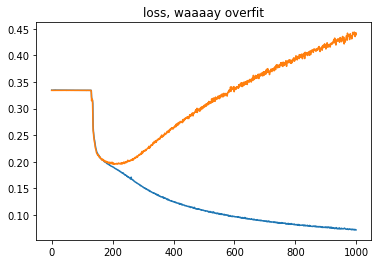

In [115]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])  ### waaaaay overfitting
plt.title('loss, waaaay overfit')

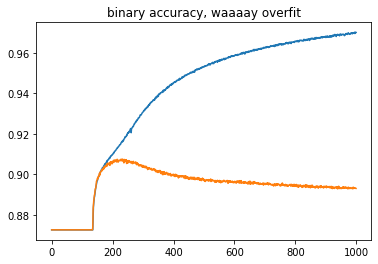

In [119]:
plt.plot(hist.history['binary_accuracy'])
plt.plot(hist.history['val_binary_accuracy'])  ### waaaaay overfitting
p=plt.title('binary accuracy, waaaay overfit')

In [23]:
#Pulling out training data to allow for other thresholds to be applied
#fulltraining = pd.concat((pd.DataFrame(y_train), data_df.loc[X_train[:, 0],['Sequence','Charge', 'SeqCharge']].reset_index(drop=True), pd.DataFrame(X_train)), axis=1)
#fulltraining.to_csv("50percentplusTraining.csv")

In [24]:
#Pulling out test data to test those other thresholds
#fulltesting = pd.concat((pd.DataFrame(y_test), data_df.loc[X_test[:, 0],['Sequence','Charge', 'SeqCharge']].reset_index(drop=True), pd.DataFrame(X_test)), axis=1)
#fulltesting.to_csv("50percentplusTesting.csv")

In [25]:
X_train

array([[0.00000e+00, 2.00000e+00, 7.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 2.00000e+00, 1.40000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.00000e+00, 3.00000e+00, 2.40000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.22844e+05, 2.00000e+00, 9.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.22845e+05, 2.00000e+00, 1.10000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.22846e+05, 2.00000e+00, 1.10000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])